# Verifying the Location of a Signal in *Kepler* Pixel Data

## Learning Goals

By the end of this tutorial, you will:

* Understand the causes of signal blending and aperture contamination in _Kepler_ and _K2_ data.
* Be able to use Lightkurve's `plot_pixels()` function to visually identify the pixel source of a signal.
* Be able to implement difference imaging to find the pixel source of a sinusoidal signal.


## Introduction

This tutorial is part of a series on handling _Kepler_ and _K2_ data with Astropy and Lightkurve. To work through this tutorial, you should be familiar with downloading and handling both **light curves** and **target pixel files** with Lightkurve, and you should have experience working with **periodograms**. We'll use light curves and periodograms to detect signal, and follow that up with detailed analysis on the pixel scale to pinpoint the signal's source.

Some useful terms to keep in mind when working with signal verification are _contamination_ and _blending_. These terms are often used interchangeably. Here, we'll use blending to refer to any scenario where flux from two or more targets become visible in one target's aperture. We use contamination to refer, more specifically, to the signal that erroneously enters the aperture.

## Imports

We'll use [Lightkurve](https://docs.lightkurve.org/) for downloading and handling _Kepler_ data throughout this tutorial. We'll also use [NumPy](https://numpy.org/) to handle arrays for aperture masks, and [Matplotlib](https://matplotlib.org) for visualizing data.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Background

The _Kepler_ space telescope observed with 4x4 arcsecond square pixels. This means that if two stars are within the same _Kepler_ pixel, it is difficult to identify which is the source of an observed signal. Fortunately, these coincidences are unlikely. But the _Kepler_ mission observed areas close to the Galactic plane, and both _Kepler_ and _K2_ observed stellar clusters, all of which are visually crowded regions. Due to crowding, there are still many cases where the true source of a signal is unclear.

The process of signal verification begins with a light curve: first, we must detect our signal. In the case of potential exoplanet transits, these will be evident in the light curve; for other phenomena, including binarity and stellar variability, we might need a periodogram to pick up on the signal. To make sure our transits really do belong to a planet, or if there's any uncertainty about the source of a stellar signal (such as, is the star in a crowded region? Is there a bright star nearby? Are we seeing multiple signals?), we need to look at the target pixel files, which will give us a more complete picture, and help us identify nearby contaminating sources.

## 2. Pixel Level Analysis

The most basic method of signal verification is to look at the pixels. In this section, we'll use tools included in Lightkurve to examine light curves and periodograms in individual pixels and help us identify the source of a signal.

### 2.1 Initial analysis

KIC 2435971 is a star of [_Kepler_ magnitude](https://keplerscience.arc.nasa.gov/the-kepler-space-telescope.html#flux-calibration) Kp = 14.7, with a massive signal. It's not impossible that this signal comes from the star, but KIC 2435971 is in the field of open cluster NGC 6791, which means it's subject to a  higher level of crowding than much of the _Kepler_ field. This could be a case of contamination; to be absolutely certain, we're going to use this star for our signal verification exercise. Let's begin by downloading a light curve; then we can produce a Lomb-Scargle Periodogram to search for repeating signals.

In [2]:
lcs = lk.search_lightcurve('KIC 2435971',  mission='Kepler', author='Kepler').download_all()

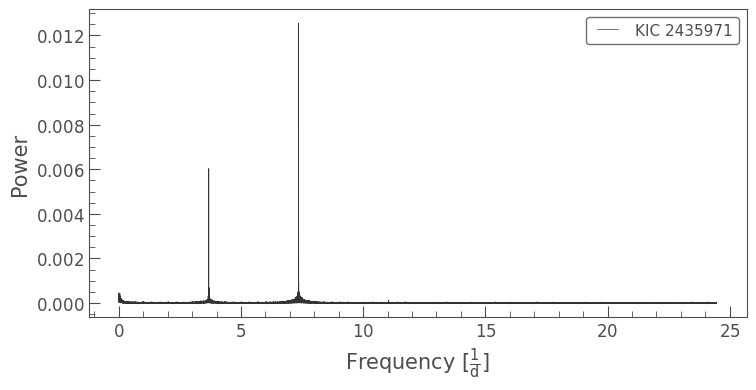

In [3]:
lc = lcs.stitch().remove_outliers()
pg = lc.to_periodogram()
pg.plot();

These high-amplitude, narrow peaks in the periodogram suggests a compact binary star.

### 2.2 Pixel-level analysis

Often, the identification of a much brighter target in the frame is enough to confirm contamination. Let's begin by looking at the target pixel file (TPF) we're going to be working with:

In [4]:
tpf = lk.search_targetpixelfile('KIC 2435971', mission='Kepler', quarter=9).download()

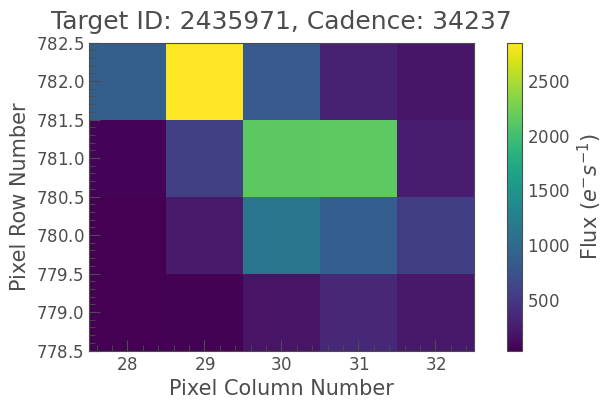

In [5]:
tpf.plot();

As you can see, there's another star very close by, at the top of the frame. This star is brighter than our target in the center, and could conceivably produce a high-amplitude periodic signal. But it's not a huge difference in flux, so we should double-check before we go ahead and claim that this is our contaminant.

Luckily, there is a utility in Lightkurve to deal with this scenario. We can look at the light curves — and periodograms — in each individual pixel, using the `plot_pixels()` function.

Let's have a look at what the function does at its most basic:

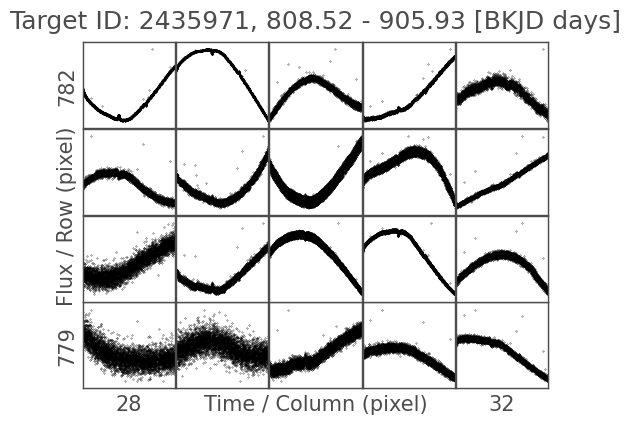

In [6]:
tpf.plot_pixels();

These are the light curves in every pixel of this TPF, for Quarter 9. We can't tell much just by looking at this, but we can give `plot_pixels()` a corrector function to flatten these light curves. To create the corrector function, we use a Python construction called a [lambda function](https://docs.python.org/3/howto/functional.html#small-functions-and-the-lambda-expression). This kind of function is known as an "anonymous" function, as it has no name. Lambda functions are just one line of code, so they're very useful for when we want a function to take another function as an argument. Here, we take a variable `x` and, assuming it's a `LightCurve` object, we can apply methods like `.remove_outliers()` as normal.

We can also overlay the TPF colors to remind us of the stars we're looking at:

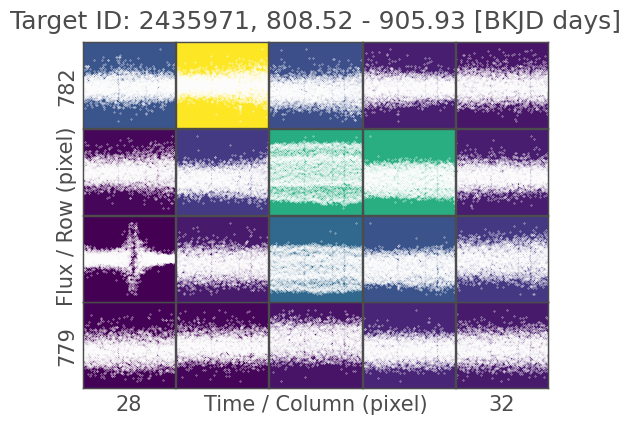

In [7]:
tpf.plot_pixels(corrector_func=lambda x: x.remove_nans().flatten().remove_outliers(), show_flux=True);

Looking at it like this, we can start to see some evidence of the signal from our periodogram above, but not enough to make a call. Let's go back to `plot_pixels()`: we can tell the function to compute a periodogram for each pixel, which should make it clear where the signal is strongest. This time, we're also going to overlay the pipeline aperture, which is the selection of pixels that went into producing the light curve for this quarter of data. The pipeline aperture is shown by red boxes around all included pixels.

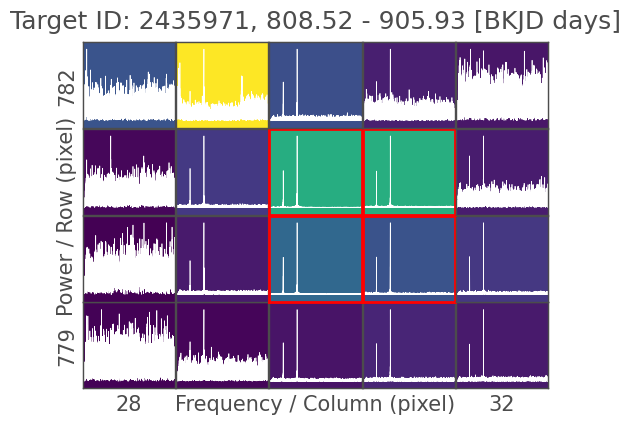

In [8]:
tpf.plot_pixels(corrector_func=lambda x: x.remove_nans().flatten().remove_outliers(), periodogram=True, show_flux=True, aperture_mask='pipeline');

We can see the two high-amplitude peaks in most of the pixels in this TPF. The key feature is the ratio of that signal's amplitude to the noise level: pixels with higher signal-to-noise ratios contain more flux from the source of the signal. This is often something we can check by eye; here, we can confirm that the signal is coming from our target star, KIC 2435971. The bright star at the top of the frame, in the yellow pixel, shows a significantly higher noise level than the green pixels below it, and the placement of the pipeline aperture reflects this.

In fact, KIC 2435971 is a [known eclipsing binary](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=KIC+2435971). This example challenges the assumption that any high-amplitude signal usually comes from the brightest star in the frame, but nevertheless shows that it's always useful to verify our signal, especially in crowded fields. If we wanted to study the bright star, we could perform **custom aperture photometry** (see the dedicated tutorial on this topic), though we wouldn't be able to exclude all of this signal, as it has such a high amplitude and contaminates so many of these pixels.

### 2.3 Identifying a contaminant

For this exercise, we're going to switch to a different star. KIC 7024511 was flagged as a _Kepler_ Object of Interest (KOI) in Quarter 6 of the mission, and given the designation KOI 311. This means that it's a potential exoplanet host, based on transits detected. Let's have a look at one quarter of data:

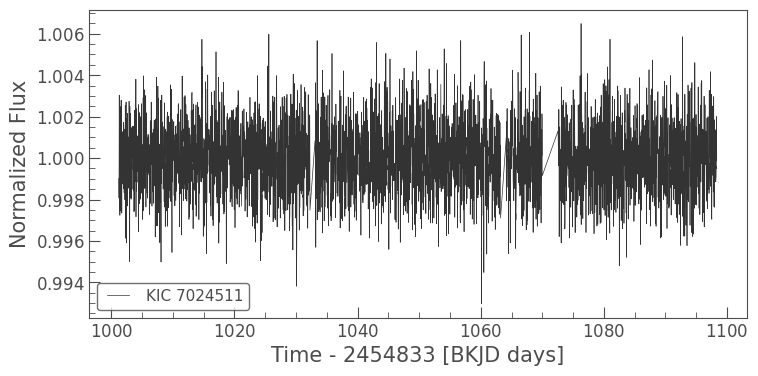

In [9]:
lc_koi = lk.search_lightcurve('KIC 7024511', mission='Kepler', quarter=11).download(quality_bitmask='hard').flatten()
lc_koi.plot();

It's hard to pick out the transits by eye, but you should be able to see one point lower than the others around 1030 BKJD (Barycentric *Kepler* Julian Date). This dip has a depth of less than 0.01%, which is consistent with the signal coming from an exoplanet. Unfortunately, it's also consistent with the diulted signal of a nearby eclipsing binary — dilution here referring to the diffuse flux towards the edges of a star's spread on the detector, where the amplitude of any variable signal can decrease. We can look at the TPF using `plot_pixels()` to confirm whether or not this is the case:

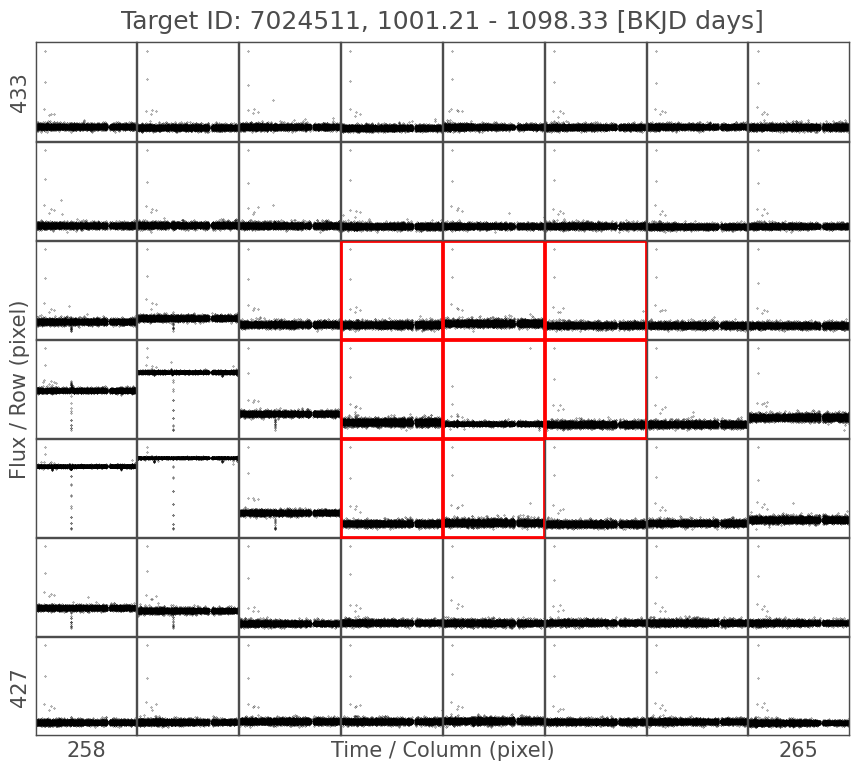

In [10]:
tpf_koi = lk.search_targetpixelfile('KIC 7024511', mission='Kepler', quarter=11).download()
tpf_koi.plot_pixels(aperture_mask='pipeline', corrector_func=lambda x: x.remove_nans().flatten());

In this case, we can clearly see an eclipse to the left of our target. The eclipsing binary is outside of the pipeline aperture, but the signal is strong enough to have contaminated it. And sure enough, if we check on the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=K00311.01&type=KEPLER_CANDIDATE), KOI 311 was designated a false positive in the first data release it was included in.

We can double-check this by using Lightkurve's [cone search](https://docs.lightkurve.org/api/lightkurve.search.search_lightcurvefile.html#lightkurve.search.search_lightcurvefile) to look for the eclipsing binary in question. So long as there's a light curve for this contaminant — and we can reasonably expect one, for such a star — we'll be able to find it with Lightkurve's search function.

(As an aside, if you run this notebook yourself, you can use the `interact_sky()` function, which returns an interactive TPF widget with targets labelled by _Gaia_ ID. This includes many targets which were not collected by _Kepler_ or _K2_.)

Making a rough guess from the size of the TPF above, we set a search radius of 20 arcseconds. And we're only going to search Quarter 11, as otherwise the function will return an entry for every available quarter.

In [11]:
lk.search_lightcurve('KIC 7024511', radius=20, mission='Kepler', author='Kepler', quarter=11)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 11,2012,Kepler,1800,kplr007024511,0.0
1,Kepler Quarter 11,2012,Kepler,1800,kplr007024530,1.7


Sure enough, there's a nearby target. The **distance** column in the search result tells us that this star is about 1.8 arcseconds away. Let's have a look at it:


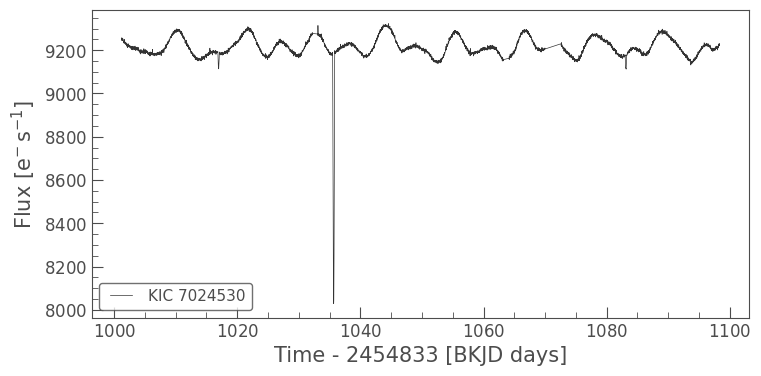

In [12]:
lc_contam = lk.search_lightcurve('KIC 7024530', mission='Kepler', author='Kepler', quarter=11).download()
lc_contam.plot();

That's our eclipse, and it seems like there's a rotational period here too. We can also confirm this by looking in the [_Kepler_ Eclipsing Binary Catalog](http://keplerebs.villanova.edu/overview/?k=7024530), or on [Simbad](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=KIC+7024530). Simbad shows an image of the contaminant, where we can see KOI 311, fainter, just beside it.

## 3. Advanced: Difference Imaging

The focus of most _Kepler_ and _K2_ signal verification research has been in validating exoplanets. Often, this is done by measuring and tracking image centroids. A centroid is the weighted average along both axes of the image, which measures the point where most flux is concentrated. If a true transit is observed, the centroid of the image will shift in time with it ([Batalha et al., 2010](https://iopscience.iop.org/article/10.1088/2041-8205/713/2/L103/pdf)). Another technique, and the focus of this section, is difference imaging ([Bryson et al., 2013](https://iopscience.iop.org/article/10.1086/671767/pdf)). Difference imaging has been used to validate signals from exocomets ([Rappaport et al., 2018](https://arxiv.org/pdf/1708.06069.pdf)), flaring stars ([Yang et al., 2017](https://iopscience.iop.org/article/10.3847/1538-4357/aa8ea2/pdf)), and binary systems ([Colman et al., 2017](https://arxiv.org/pdf/1705.00621.pdf)).

For vetting exoplanet candidates, difference imaging begins with a selection of flux measurements, both in- and out-of-phase with the transit. Using the frames from TPF images, we take an average of each collection of frames and subtract the in-phase fluxes from the out-of-phase fluxes, resulting in a _difference image_. We can then measure the centroid of the difference image, which will move outside of the optimal aperture if the star is contaminated. We can also visually identify the pixel where the variable flux is "brightest." 

We're going to work through a basic case here, which is applicable to a broad variety of stellar signals. For any periodic and quasi-sinusoidal signal, difference imaging works by selecting flux frames at timestamps around the maxima and minima of the signal, which is equivalent to working in- and out-of-phase with a transit. The result is a pixel image where the brightest pixels are those where the periodic signal is strongest.



### 3.1 Determining the signal period

Let's go back to KIC 2435971. We're going to use the TPF we downloaded above for difference imaging; as it's a pixel-level method, we can only use one quarter or campaign of _Kepler_ data at a time. But for difference imaging to work well, we need as much data as possible to extract the period for differencing, so we'll use the stitched light curve we prepared earlier. We've already downloaded the data above, so let's remind ourselves of what the periodogram looks like:

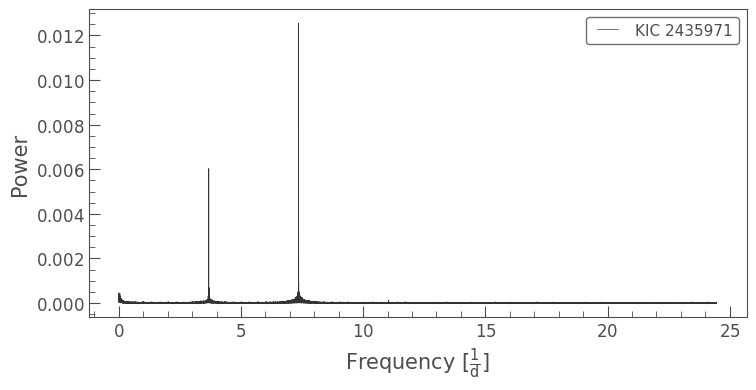

In [13]:
pg.plot();

From this, we can extract the period of the highest amplitude signal; you will have seen the `period_at_max_power` argument in one of the periodogram tutorials.

In [14]:
peak = pg.frequency_at_max_power
period = pg.period_at_max_power
print(f'Frequency: {peak:.3f}\nPeriod: {period:.3f}')

Frequency: 7.358 1 / d
Period: 0.136 d


### 3.2 Determining the maximum and minimum phase times

To find our maxima and minima, we're going to start by phase-folding the light curve. This will help us identify the maxima and minima of the periodic signal.

Note that when we phase-fold the curve below, we use the `epoch_time` argument to shift the phase curve's zero position. This helps us pick out the maxima and minima of the phase curve more clearly; however, it's a matter of trial and error to choose a suitable epoch time for any given target. In many cases, it will suffice not to set the argument at all. An alternative to experimenting with the epoch time is appending the phased light curve to itself, which guarantees at least one clear maximum and one clear minimum. This is a better method for an automated difference imaging pipeline, but is more complicated to implement.

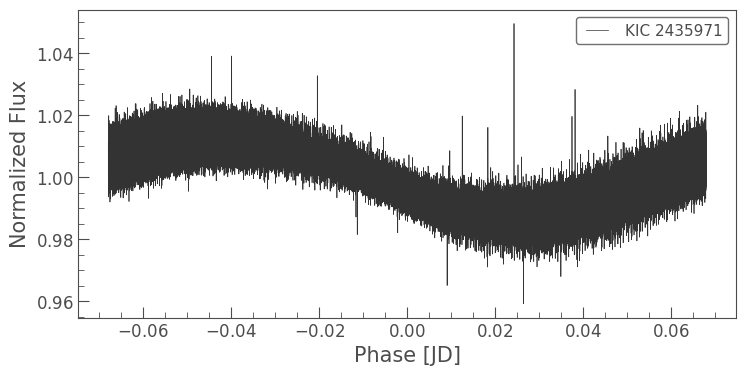

In [15]:
folded = lc.fold(period, epoch_time=0.5)
folded.plot();

This looks promising, but there's still a great deal of noise in the light curve. When we smooth the light curve by putting it into 0.001-day bins, we can see the sinusoidal trend more clearly:

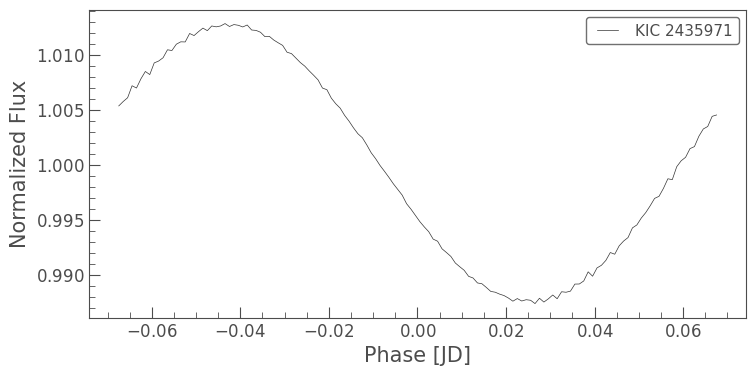

In [16]:
folded2 = folded.bin(time_bin_size=0.001)
folded2.plot();

We're going to identify the maxima and minima using the binned phase curve. Once we have identified two ranges in phase space, we'll collect the timestamps within those ranges from the original phase curve. Then we'll compare those timestamps to our TPF data to pick out the corresponding flux frames for each range.

It can be tricky to decide how much flux to collect on either side of the maxima and minima. A good value is a tolerance of 5% of the phase curve, which means that we end up using 10% of the light curve at maximum phase and 10% of the light curve at minimum phase for the difference image. This ensures that we're using enough to get a reliable difference image, given some uncertainty in where the maxima and minima actually are, but not so much that the difference image is meaningless.

This next part uses some Python tricks to help us quickly determine which timestamps to use in calculating our difference image. If you find the code below unfamiliar, it might be helpful to read up on [NumPy `where()`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) and [list comprehension](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python).

In [17]:
full_phase_range = folded2.phase[-1].value - folded2.phase[0].value
tolerance = 0.05 * full_phase_range
min_phase = folded2.time[np.argmin(folded2.flux)].value 
max_phase = folded2.time[np.argmax(folded2.flux)].value

min_timestamps = folded.time_original[np.where((folded.time > min_phase - tolerance) 
                                             & (folded.time < min_phase + tolerance))].value
max_timestamps = folded.time_original[np.where((folded.time > max_phase - tolerance)
                                             & (folded.time < max_phase + tolerance))].value

In [18]:
one_quarter_minima = [f for (f, t) in zip(tpf.flux.value, tpf.time.value) if t in min_timestamps]
one_quarter_maxima = [f for (f, t) in zip(tpf.flux.value, tpf.time.value) if t in max_timestamps]

### 3.3 Computing the difference image

Now that we have identified the maximum and minimum phase timestamps to use, we can calculate our difference image! We're also going to calculate an average of the whole quarter, and we can use Matplotlib to display them side by side for clear comparison. Note that we're also flipping the images, so that they have the same orientation as the Lightkurve TPF plots.

In [19]:
avg_image = np.nanmean(tpf.flux.value, axis=0)
diff_image = np.abs(np.nanmean(one_quarter_maxima, axis=0) - np.nanmean(one_quarter_minima, axis=0))

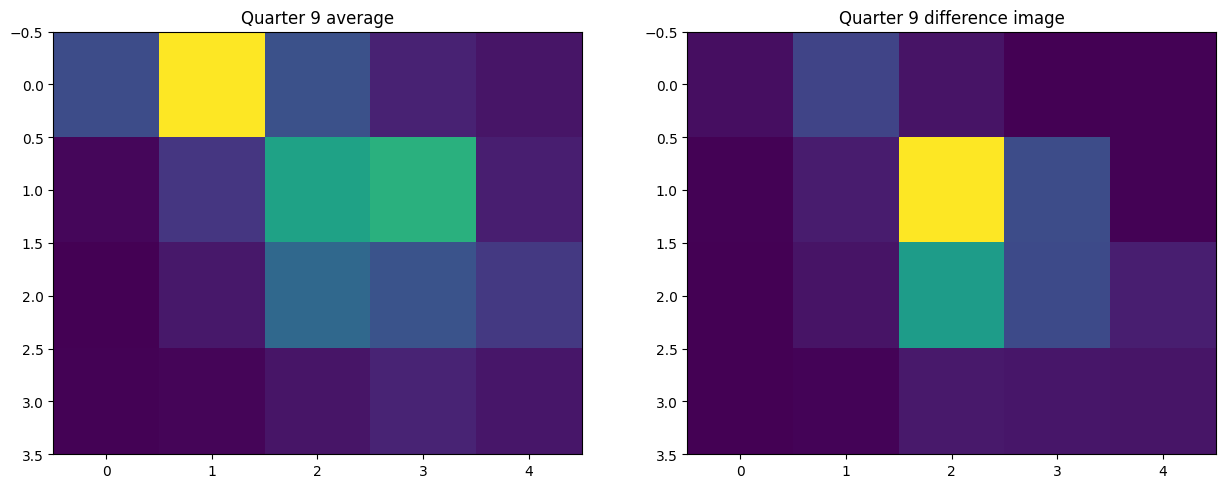

In [20]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.flipud(avg_image))
ax[0].set_title('Quarter 9 average')
ax[1].imshow(np.flipud(diff_image))
ax[1].set_title('Quarter 9 difference image')
fig.set_size_inches((15,6))

Let's take a moment to think about what these images tell us. In the average image, we can see our two stars, the target and the brighter star at the top of the frame. In the difference image, the pixel with the highest difference flux is one of the central pixels, indicating that the signal is coming from the target star, just as we saw when we looked at pixel-level periodograms with `plot_pixels()`.

We can still see a little bit of signal in some other pixels. This is down to noise, which we saw in our first folded light curve. Even with a clear signal like the one from KIC 2435971, most difference images will show some degree of noise. But it's good to note that the difference flux in the pixel that hosts the bright nearby star is greatly diminished, as we would expect.

So, since we can get this information from `plot_pixels()`, why would we want to go to the effort of difference imaging? Sometimes the signal in a periodogram may not be visually clear from using `plot_pixels()`, but there would still be enough signal for it to show up in a difference image. Difference imaging is also useful for clarifying association in a crowded field, or where bright stars are involved. If a signal is spread out across a lot of pixels, difference imaging can pinpoint where it's strongest; this is particularly evident in the case of KIC 2435971. And of course, it's always good to confirm our conclusions using a different method!

## About this Notebook

**Author:** [Isabel Colman](http://orcid.org/0000-0001-8196-516X) (`isabel.colman@sydney.edu.au`)

**Updated on:** 2020-09-15

# Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [21]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>